In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import TensorDataset, DataLoader

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch.nn.parameter import Parameter
from torchvision.datasets import MNIST
from sklearn import metrics

In [2]:
def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

In [3]:
letter_trainset = MNIST("../", train=True, download=False)
letter_testset  = MNIST("../", train=False, download=False)
letter_trainset.data[0].size()

torch.Size([28, 28])

In [4]:
n_train_data = 600
n_testn_data = 200

# Train
train_to = letter_trainset.data[letter_trainset.targets == 15][:n_train_data].float()/255
train_tx = letter_trainset.data[letter_trainset.targets == 24][:n_train_data].float()/255

train_lo = letter_trainset.targets[letter_trainset.targets == 15][:n_train_data]
train_lx = letter_trainset.targets[letter_trainset.targets == 24][:n_train_data]
train_lo[:] = 1
train_lx[:] = 2

# train_t_ = torch.zeros_like(train_to)
train_t_ = torch.randint_like(train_to, low=0, high=20)/255
train_l_ = torch.zeros_like(train_lo)


x_train = (torch.cat((train_to,train_tx,train_t_)) > 0.1) * 1.0
y_train = torch.cat((train_lo,train_lx,train_l_))

# test
test_to = letter_testset.data[letter_testset.targets == 15][n_train_data:n_train_data+n_testn_data].float()/255
test_tx = letter_testset.data[letter_testset.targets == 24][n_train_data:n_train_data+n_testn_data].float()/255

test_lo = letter_testset.targets[letter_testset.targets == 15][n_train_data:n_train_data+n_testn_data]
test_lx = letter_testset.targets[letter_testset.targets == 24][n_train_data:n_train_data+n_testn_data]
test_lo[:] = 1
test_lx[:] = 2

# test_t_ = torch.zeros_like(test_to)
test_t_ = torch.randint_like(test_to, low=0, high=20)/255
test_l_ = torch.zeros_like(test_lo)

x_test = (torch.cat((test_to,test_tx,test_t_)) > 0.1) * 1.0
y_test = torch.cat((test_lo,test_lx,test_l_))

print("Train:",x_train.shape)
print("Test :",x_test.shape)

Train: torch.Size([1800, 28, 28])
Test : torch.Size([600, 28, 28])


In [5]:
train_set = TensorDataset(x_train, y_train)
test_set  = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_set, shuffle=True, batch_size=64, drop_last=True)
test_loader  = DataLoader(test_set, shuffle=True, batch_size=64, drop_last=True)

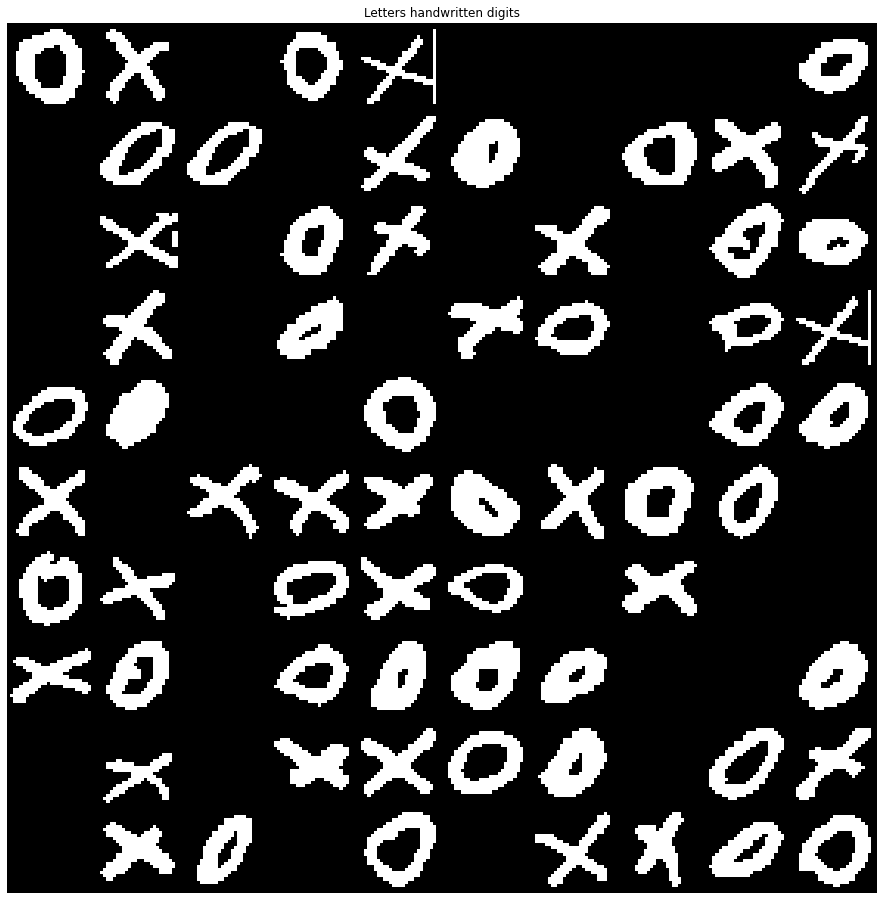

In [6]:
# plot a few MNIST examples
idx, dim, classes = 0, 28, 10
# create empty canvas
canvas = np.zeros((dim*classes, classes*dim))

# fill with tensors
for i in range(classes):
    for j in range(classes):
        canvas[i*dim:(i+1)*dim, j*dim:(j+1)*dim] = x_train[idx].reshape((dim, dim))
        idx = np.random.randint(0, n_train_data*3)

# visualize matrix of tensors as gray scale image
plt.figure(figsize=(16, 16))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('Letters handwritten digits')
plt.show()

In [7]:
#Hyperparameters
num_classes = 3
num_features = x_train.shape[1]

# define network
class Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        # Your code here!
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.batchN1 = nn.BatchNorm2d(16)
        self.batchN2 = nn.BatchNorm2d(32)
        self.drop    = nn.Dropout(p=0.5)
        
        self.pool  = nn.MaxPool2d(2, 2)
        self.flat = nn.Flatten()
        
        self.fc1   = nn.Linear(800, 256)
        self.fc2   = nn.Linear(256, 128)
        self.fc3   = nn.Linear(128, self.num_classes)
        self.log   = nn.LogSoftmax(dim=1)
        self.Lrelu = nn.LeakyReLU()
        

    def forward(self, x):
        # Your code here!
        x = x.view(64,1,28,28)
        x = self.drop(self.batchN1(self.pool(self.Lrelu(self.conv1(x)))))
        x = self.drop(self.batchN2(self.pool(self.Lrelu(self.conv2(x)))))
        x = self.flat(x)
        x = self.Lrelu(self.fc1(x))
        x = self.Lrelu(self.fc2(x))
        x = self.fc3(x)
        x = self.log(x)
        return x


model = Model(num_classes)
# use cuda or cpu
if torch.cuda.is_available(): device = torch.device('cuda')  
else:                         device = torch.device('cpu')
model.load_state_dict(torch.load('model.pth', weights_only=False))
model.to(device)
print(device)
print(model)

cuda
Model(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (batchN1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchN2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=800, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
  (log): LogSoftmax(dim=1)
  (Lrelu): LeakyReLU(negative_slope=0.01)
)


In [8]:
optimizer = optim.SGD(model.parameters(), lr=0.005)
loss_fn = nn.CrossEntropyLoss()

# Build the training loop

We train the network by calculating the gradient w.r.t the cost function and update the parameters in direction of the negative gradient. 


When training neural network you always use mini batches. Instead of calculating the average gradient using the entire dataset you approximate the gradient using a mini-batch of typically 16 to 256 samples. The paramters are updated after each mini batch. Networks converge much faster using mini batches because the parameters are updated more often.

We build a loop that iterates over the training data. Remember that the parameters are updated each time ``optimizer.step()`` is called.

In [25]:
batch_size = 64
num_epochs = 100
validation_every_steps = 25

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in (pbar:=tqdm(range(num_epochs))):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.
        # Your code here!
        optimizer.zero_grad()
        output = model(inputs)
        train_loss = loss_fn(output, targets)
        train_loss.backward()
        
        optimizer.step()
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            # print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            # print(f"                 test accuracy: {valid_accuracies[-1]}")
            pbar.set_description(f"Step {step:<5}   training accuracy: {train_accuracies[-1]:.3f}   test accuracy: {valid_accuracies[-1]:.3f}")

print("Finished training.")

  0%|          | 0/100 [00:00<?, ?it/s]

Finished training.


In [9]:
valid_accuracies_batches = []
with torch.no_grad():
    model.eval()
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        print(output)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
        valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

    model.train()
print(np.sum(valid_accuracies_batches) / len(test_set))

tensor([[-5.9465e+00, -6.6356e+00, -3.9355e-03],
        [-8.9979e+00, -5.3677e-04, -7.7920e+00],
        [-8.1045e+00, -9.7180e+00, -3.6245e-04],
        [-6.6055e+00, -3.5776e-03, -6.1110e+00],
        [-5.6548e+00, -7.7762e-03, -5.4620e+00],
        [-9.6575e+00, -2.7557e-04, -8.4608e+00],
        [-1.4328e-04, -9.9562e+00, -9.2525e+00],
        [-1.4328e-04, -9.9562e+00, -9.2525e+00],
        [-9.7847e+00, -2.3493e-04, -8.6304e+00],
        [-1.4328e-04, -9.9562e+00, -9.2525e+00],
        [-1.4328e-04, -9.9562e+00, -9.2525e+00],
        [-7.2324e+00, -7.6203e+00, -1.2140e-03],
        [-8.4578e+00, -9.5870e+00, -2.8094e-04],
        [-6.9238e+00, -6.8924e+00, -2.0015e-03],
        [-1.4328e-04, -9.9562e+00, -9.2525e+00],
        [-1.4328e-04, -9.9562e+00, -9.2525e+00],
        [-4.2400e+00, -4.2358e-02, -3.6095e+00],
        [-6.5507e+00, -7.4926e+00, -1.9883e-03],
        [-1.4328e-04, -9.9562e+00, -9.2525e+00],
        [-1.4328e-04, -9.9562e+00, -9.2525e+00],
        [-1.4328e-04

In [10]:
with torch.no_grad():
    model.eval()

    output = model(torch.zeros_like(inputs))
    print(output)

    model.train()
print(np.sum(valid_accuracies_batches) / len(test_set))

tensor([[-1.4328e-04, -9.9562e+00, -9.2525e+00],
        [-1.4328e-04, -9.9562e+00, -9.2525e+00],
        [-1.4328e-04, -9.9562e+00, -9.2525e+00],
        [-1.4328e-04, -9.9562e+00, -9.2525e+00],
        [-1.4328e-04, -9.9562e+00, -9.2525e+00],
        [-1.4328e-04, -9.9562e+00, -9.2525e+00],
        [-1.4328e-04, -9.9562e+00, -9.2525e+00],
        [-1.4328e-04, -9.9562e+00, -9.2525e+00],
        [-1.4328e-04, -9.9562e+00, -9.2525e+00],
        [-1.4328e-04, -9.9562e+00, -9.2525e+00],
        [-1.4328e-04, -9.9562e+00, -9.2525e+00],
        [-1.4328e-04, -9.9562e+00, -9.2525e+00],
        [-1.4328e-04, -9.9562e+00, -9.2525e+00],
        [-1.4328e-04, -9.9562e+00, -9.2525e+00],
        [-1.4328e-04, -9.9562e+00, -9.2525e+00],
        [-1.4328e-04, -9.9562e+00, -9.2525e+00],
        [-1.4328e-04, -9.9562e+00, -9.2525e+00],
        [-1.4328e-04, -9.9562e+00, -9.2525e+00],
        [-1.4328e-04, -9.9562e+00, -9.2525e+00],
        [-1.4328e-04, -9.9562e+00, -9.2525e+00],
        [-1.4328e-04

In [27]:
torch.save(model.state_dict(), "model.pth")

In [ ]:
import cv2
capture1 = cv2.VideoCapture(0)
while True:
    ret, img = capture1.read() # Read an image
    cv2.imshow("ImageWindow", img) # Display the image
    # if (cv2.waitKey(2) >= 0): # If the user presses a key, exit while loop
    #     break
    k = cv2.waitKey(33)
    if k==27:    # Esc key to stop
        break
    elif k==-1:  # normally -1 returned,so don't print it
        continue
    else:
        print(k)
cv2.destroyAllWindows() # Close window
cv2.VideoCapture(0).release() # Release video device

In [ ]:
cv2.destroyAllWindows() # Close window
cv2.VideoCapture(0).release() # Release video device